In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from utils import plot_utils
plot_utils.set_plotting_defaults()

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=False
fitting_type = 'texture_gabor_ridge_4ori_4sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = plot_utils.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
plot_utils.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01_surface/texture_gabor_ridge_4ori_4sf/Sep-12-2021_2354_30/all_fit_params

dict_keys(['voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'feature_info', 'nonlin_fn', 'padding_mode', 'autocorr_output_pix'])
voxel_mask: shape (453622,)
image_order: shape (7500,)
voxel_index: len 1
voxel_roi: len 2
voxel_ncsnr: shape (453622,)
aperture = 1.0
aperture_rf_range = 1.1
models: shape (875, 3)
n_prf_sd_out = 2
best_losses: shape (66545, 3)
best_lambdas: shape (66545, 3)
best_params: len 6
lambd

In [3]:
out['image_order']

array([ 625, 5012, 4849, ..., 8502, 9853, 1175], dtype=uint16)

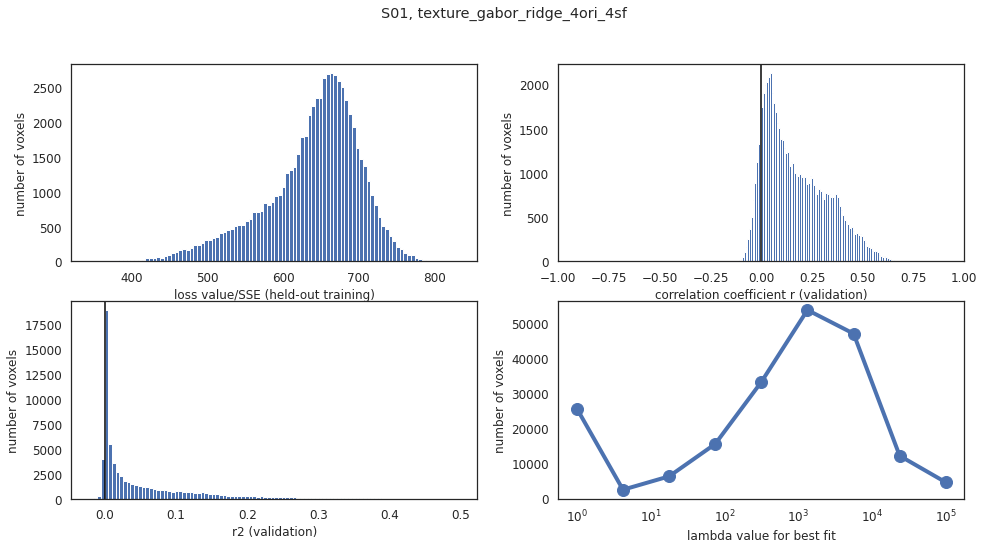

In [3]:
plot_utils.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [6]:
# plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

In [3]:
plot_utils.plot_summary_pycortex(subject, fitting_type, out, port=33333)

navigate browser to: 127.0.0.1:33333
Started server on port 33333


In [4]:
plot_utils.plot_texture_pars_pycortex(subject, fitting_type, out, port=33333)

ValueError: operands could not be broadcast together with shapes (66545,9) (66545,2) 

In [20]:
import cortex

if 'texture' not in fitting_type:
    raise ValueError('this plot is just for texture model')        


retlabs, catlabs, ret_group_names, categ_group_names = plot_utils.get_combined_rois(subject, out)

if out['brain_nii_shape'] is not None:
    raise ValueError('Cannot use this function for data that is in volume space!')

substr = 'subj%02d'%subject

val_r2 = plot_utils.get_r2(out)
# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# n_feature_types = len(out['feature_info'][1])
if 'partial_version_names' in out.keys():
    partial_version_names = out['partial_version_names']
    n_feature_types = len(partial_version_names)-1
    ve_names = [partial_version_names[0] + ' - ' + partial_version_names[pp] for pp in range(1,len(partial_version_names))]
else:
    n_feature_types = len(out['feature_info'][1])
    ve_names = ['Var expl: %s'%ff for ff in out['feature_info'][1]]

In [27]:
out['partial_masks'][:,0:40]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

In [23]:
   
port=33333
    
    
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_feature_types]) - val_r2[:,1:] 

# which feature type explains most unique variance, for each voxel?
max_ind = np.argmax(var_expl, axis=1)
colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

voxel_mask = out['voxel_mask']

vemin = -0.05
vemax = 0.05

dat2plot = {'ROI labels (retinotopic)': cortex.Vertex(data = plot_utils.get_full_surface(retlabs, voxel_mask), \
                                                subject=substr, cmap='Accent',vmin = 0, vmax = np.max(retlabs)), \
            'ROI labels (category-selective)': cortex.Vertex(data = plot_utils.get_full_surface(catlabs, voxel_mask), \
                                                subject=substr, cmap='Accent',vmin = 0, vmax = np.max(catlabs)), \
            'Preferred feature type (based on var expl)': \
                                cortex.Vertex(data = plot_utils.get_full_surface(max_ind, voxel_mask), \
                                                subject=substr, cmap='plasma_r', vmin=0, vmax=n_feature_types)}

for fi, ff in enumerate(ve_names):
    dat2plot[ff] = cortex.Vertex(data = plot_utils.get_full_surface(var_expl[:,fi], voxel_mask), \
                                                subject=substr, vmin=vemin, vmax=vemax)

# Open the webviewer
print('navigate browser to: 127.0.0.1:%s'%port)
cortex.webshow(dat2plot, open_browser=True, port=port, title = 'S%02d, %s'%(subject, fitting_type))

navigate browser to: 127.0.0.1:33333
Started server on port 33333


<JS: window.viewer>

In [24]:
var_expl.shape

(66545, 2)

In [8]:
out['feature_info']

[array([1, 1, 1, ..., 1, 1, 1]),
 ['pixel_stats',
  'complex_feature_means',
  'simple_feature_means',
  'complex_feature_autocorrs',
  'simple_feature_autocorrs',
  'complex_within_scale_crosscorrs',
  'simple_within_scale_crosscorrs',
  'complex_across_scale_crosscorrs',
  'simple_across_scale_crosscorrs']]

In [9]:
out['partial_version_names']

['full_model', 'just_mean_magnitudes', 'just_all_other_texture_feats']

In [11]:
out['partial_masks']

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [31]:
def get_var_part(combined, just_a, just_b):
    
    unique_a = combined - just_b
    unique_b = combined - just_a
    shared_ab = just_a + just_b - combined

    return shared_ab, unique_a, unique_b

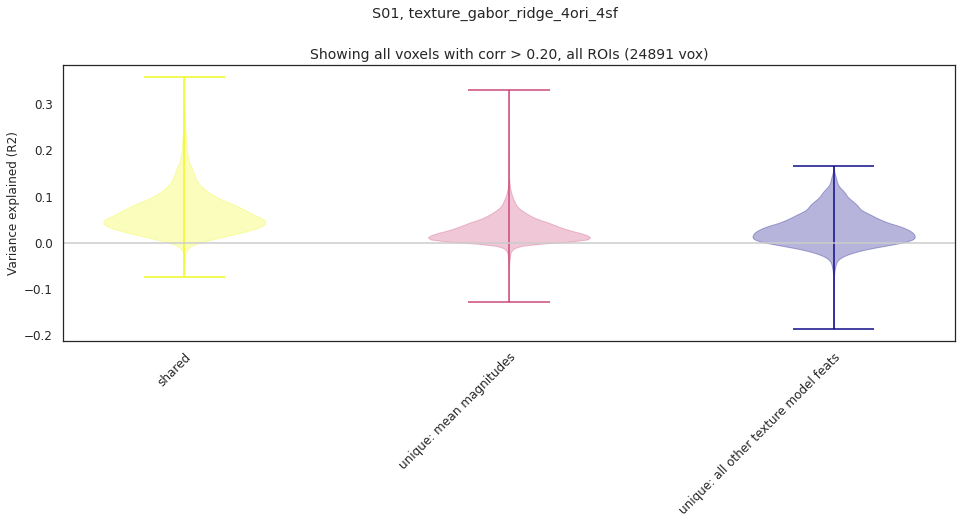

In [36]:
val_r2 = plot_utils.get_r2(out)


# A = the 'mean magnitude' features
# B = all other features in texture model.

shared_ab, unique_a, unique_b = get_var_part(combined = val_r2[:,0, ], just_a = val_r2[:,1], just_b = val_r2[:,2])
ve_names = ['shared', 'unique: mean magnitudes', 'unique: all other texture model feats']
ve_to_plot = [shared_ab, unique_a, unique_b]

plt.figure(figsize=(16,8))

roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
    n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

n_var_parts = len(ve_to_plot)

colors = cm.plasma(np.linspace(0,1,n_var_parts))
colors = np.flipud(colors)

abv_thresh = val_cc[:,0]>cc_cutoff
inds2use = abv_thresh

for ve in range(n_var_parts):
    
    parts = plt.violinplot(ve_to_plot[ve][inds2use], [ve])
    for pc in parts['bodies']:
        pc.set_color(colors[ve,:])
    parts['cbars'].set_color(colors[ve,:])
    parts['cmins'].set_color(colors[ve,:])
    parts['cmaxes'].set_color(colors[ve,:])
    
plt.xticks(ticks=np.arange(0,n_var_parts),labels=ve_names,rotation=45, ha='right',rotation_mode='anchor')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.ylabel('Variance explained (R2)')

plt.title('Showing all voxels with corr > %.2f, all ROIs (%d vox)'%(cc_cutoff, np.sum(inds2use)))

plt.suptitle('S%02d, %s'%(subject, fitting_type))
plt.gcf().subplots_adjust(bottom=0.4)
    

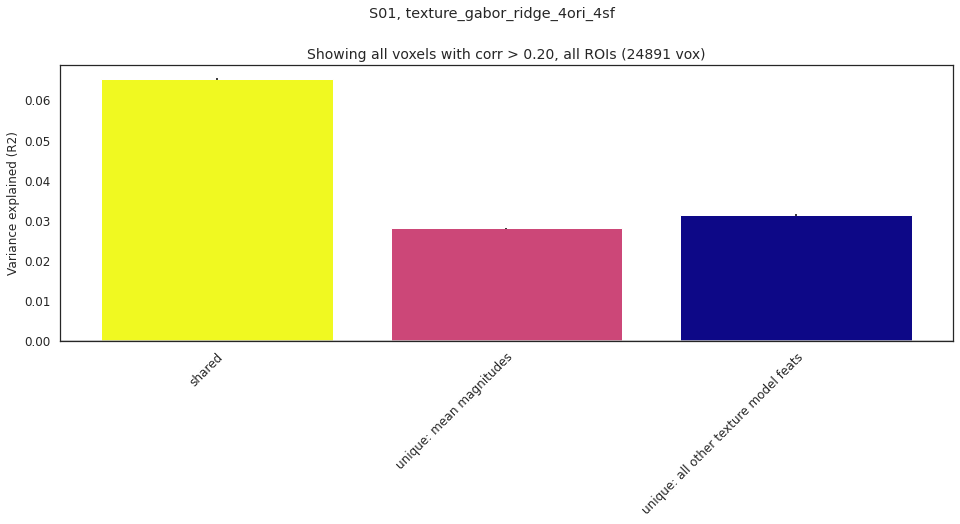

In [37]:
val_r2 = plot_utils.get_r2(out)

# A = the 'mean magnitude' features
# B = all other features in texture model.

shared_ab, unique_a, unique_b = get_var_part(combined = val_r2[:,0, ], just_a = val_r2[:,1], just_b = val_r2[:,2])
ve_names = ['shared', 'unique: mean magnitudes', 'unique: all other texture model feats']
ve_to_plot = [shared_ab, unique_a, unique_b]

plt.figure(figsize=(16,8))

roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
    n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

n_var_parts = len(ve_to_plot)

colors = cm.plasma(np.linspace(0,1,n_var_parts))
colors = np.flipud(colors)

abv_thresh = val_cc[:,0]>cc_cutoff
inds2use = abv_thresh

for ve in range(n_var_parts):
    
    mean = np.mean(ve_to_plot[ve][inds2use])
    sem = np.std(ve_to_plot[ve][inds2use])/np.sqrt(np.sum(inds2use))

    plt.bar(ve, mean, color=colors[ve,:])
    plt.errorbar(ve, mean, sem, color = colors[ve,:], ecolor='k')
    
plt.xticks(ticks=np.arange(0,n_var_parts),labels=ve_names,rotation=45, ha='right',rotation_mode='anchor')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.ylabel('Variance explained (R2)')

plt.title('Showing all voxels with corr > %.2f, all ROIs (%d vox)'%(cc_cutoff, np.sum(inds2use)))

plt.suptitle('S%02d, %s'%(subject, fitting_type))
plt.gcf().subplots_adjust(bottom=0.4)
      

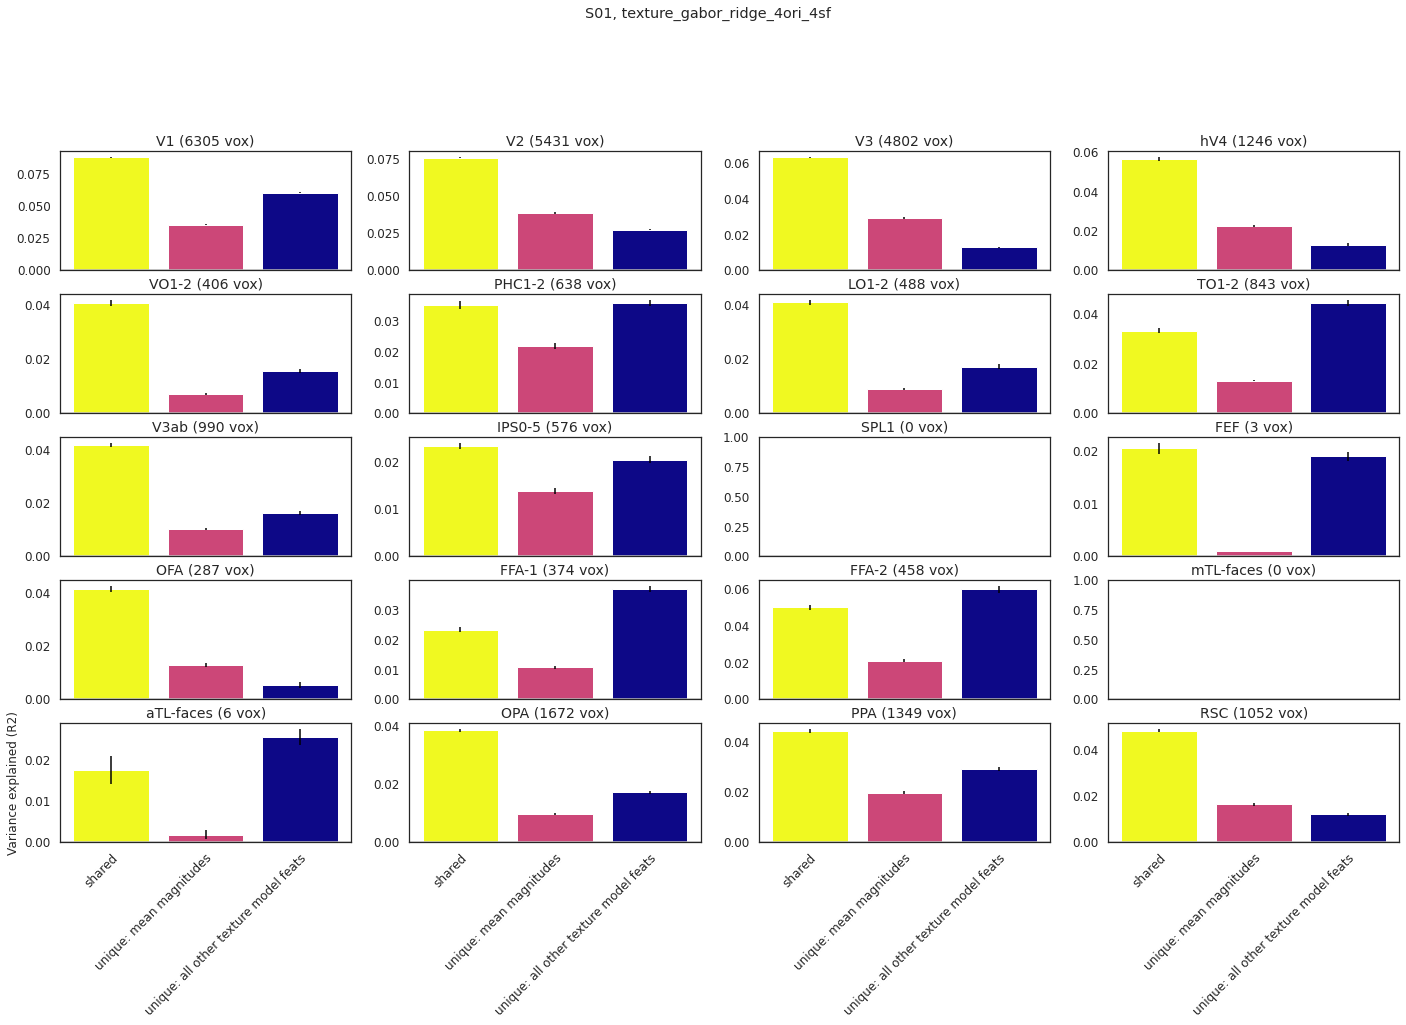

In [38]:
val_r2 = plot_utils.get_r2(out)

# A = the 'mean magnitude' features
# B = all other features in texture model.

shared_ab, unique_a, unique_b = get_var_part(combined = val_r2[:,0, ], just_a = val_r2[:,1], just_b = val_r2[:,2])
ve_names = ['shared', 'unique: mean magnitudes', 'unique: all other texture model feats']
ve_to_plot = [shared_ab, unique_a, unique_b]

roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
    n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

# Preferred feature type, based on unique var explained. Separate plot each ROI.
plt.figure(figsize=(24,20))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

n_var_parts = len(ve_to_plot)

colors = cm.plasma(np.linspace(0,1,n_var_parts))
colors = np.flipud(colors)

for rr in range(n_rois):

    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]

    abv_thresh = val_cc[:,0]>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)


    plt.subplot(npx,npy,rr+1)

    if np.sum(inds2use)>0:

        for ve in range(n_var_parts):

            mean = np.mean(ve_to_plot[ve][inds2use])
            sem = np.std(ve_to_plot[ve][inds2use])/np.sqrt(np.sum(inds2use))

            plt.bar(ve, mean, color=colors[ve,:])
            plt.errorbar(ve, mean, sem, color = colors[ve,:], ecolor='k')
    
    plt.xticks(ticks=np.arange(0,n_var_parts),labels=ve_names,rotation=45, ha='right',rotation_mode='anchor')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    if rr==n_rois-4:
        plt.ylabel('Variance explained (R2)')
    elif rr<n_rois-4:
        plt.xticks([])

    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))
        
plt.suptitle('S%02d, %s'%(subject, fitting_type))
plt.gcf().subplots_adjust(bottom=0.4)
   

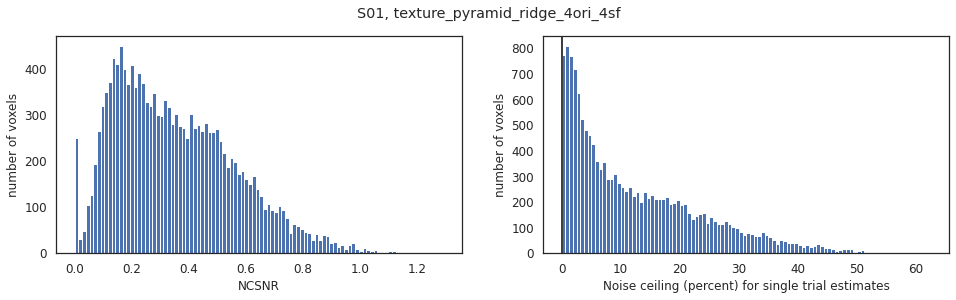

In [4]:
plot_utils.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

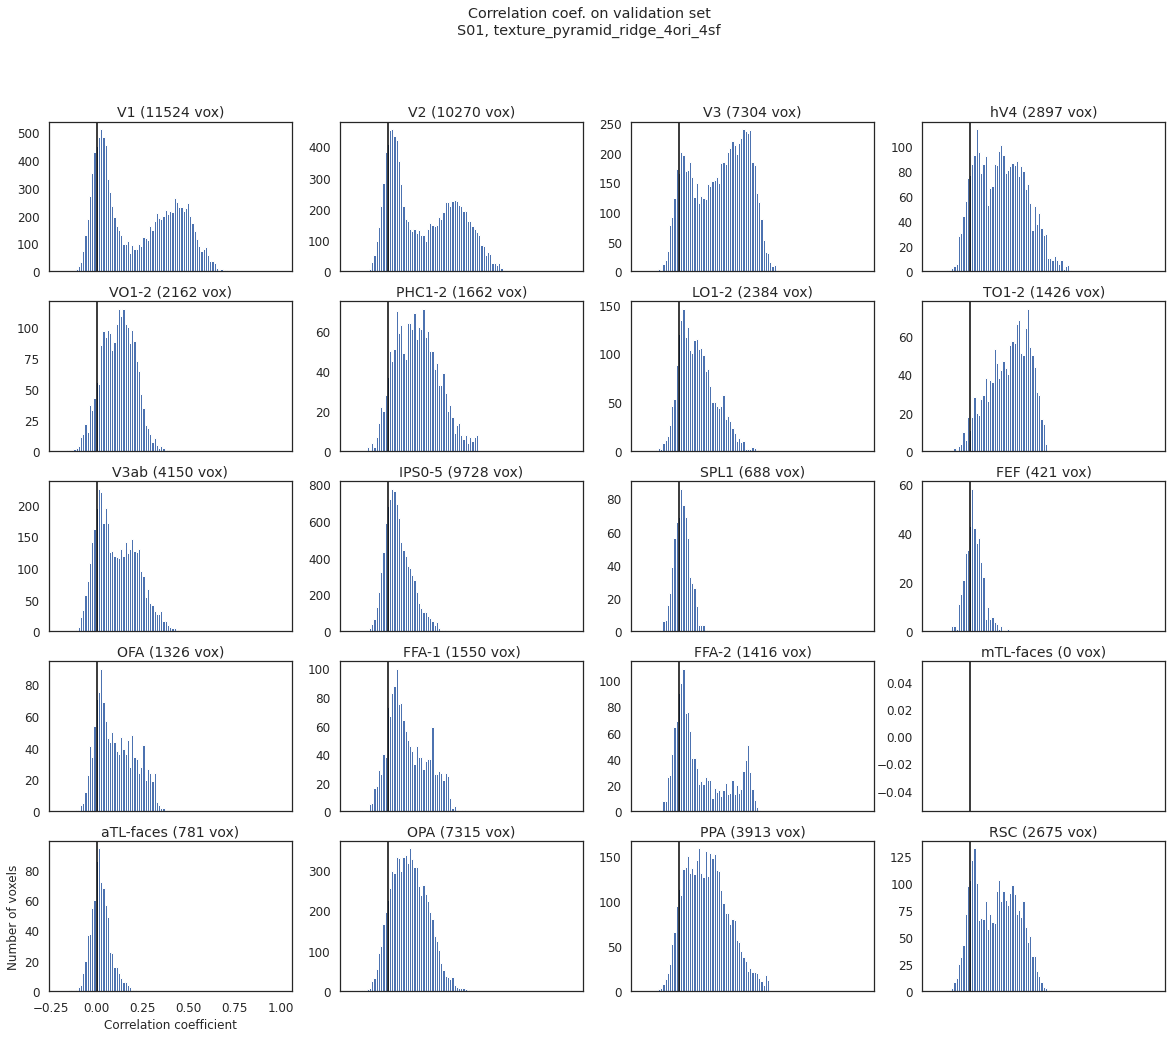

In [6]:
plot_utils.plot_cc_each_roi(subject, fitting_type,out, fig_save_folder)

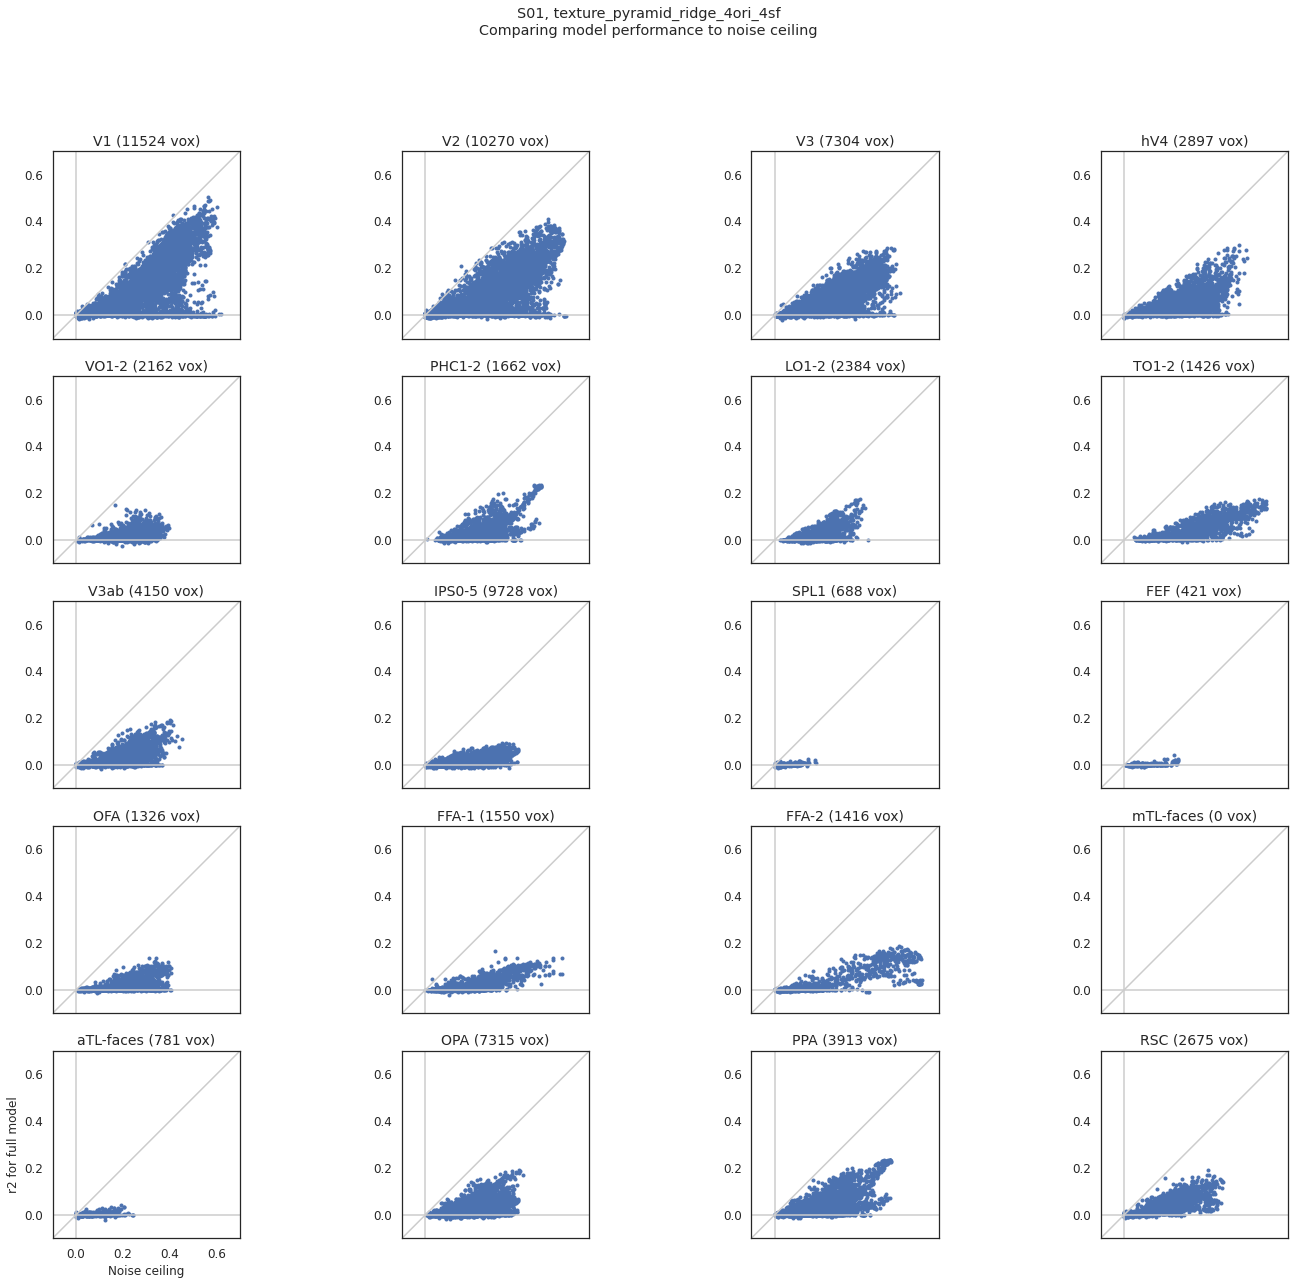

In [7]:
plot_utils.plot_r2_vs_nc(subject, fitting_type,out, fig_save_folder)

In [8]:
plot_utils.plot_spatial_rf_circles(subject, fitting_type,out, cc_cutoff = 0.20, fig_save_folder=fig_save_folder)

Error in callback <function flush_figures at 0x7f75b0f642f0> (for post_execute):


KeyboardInterrupt: 

Stopping server


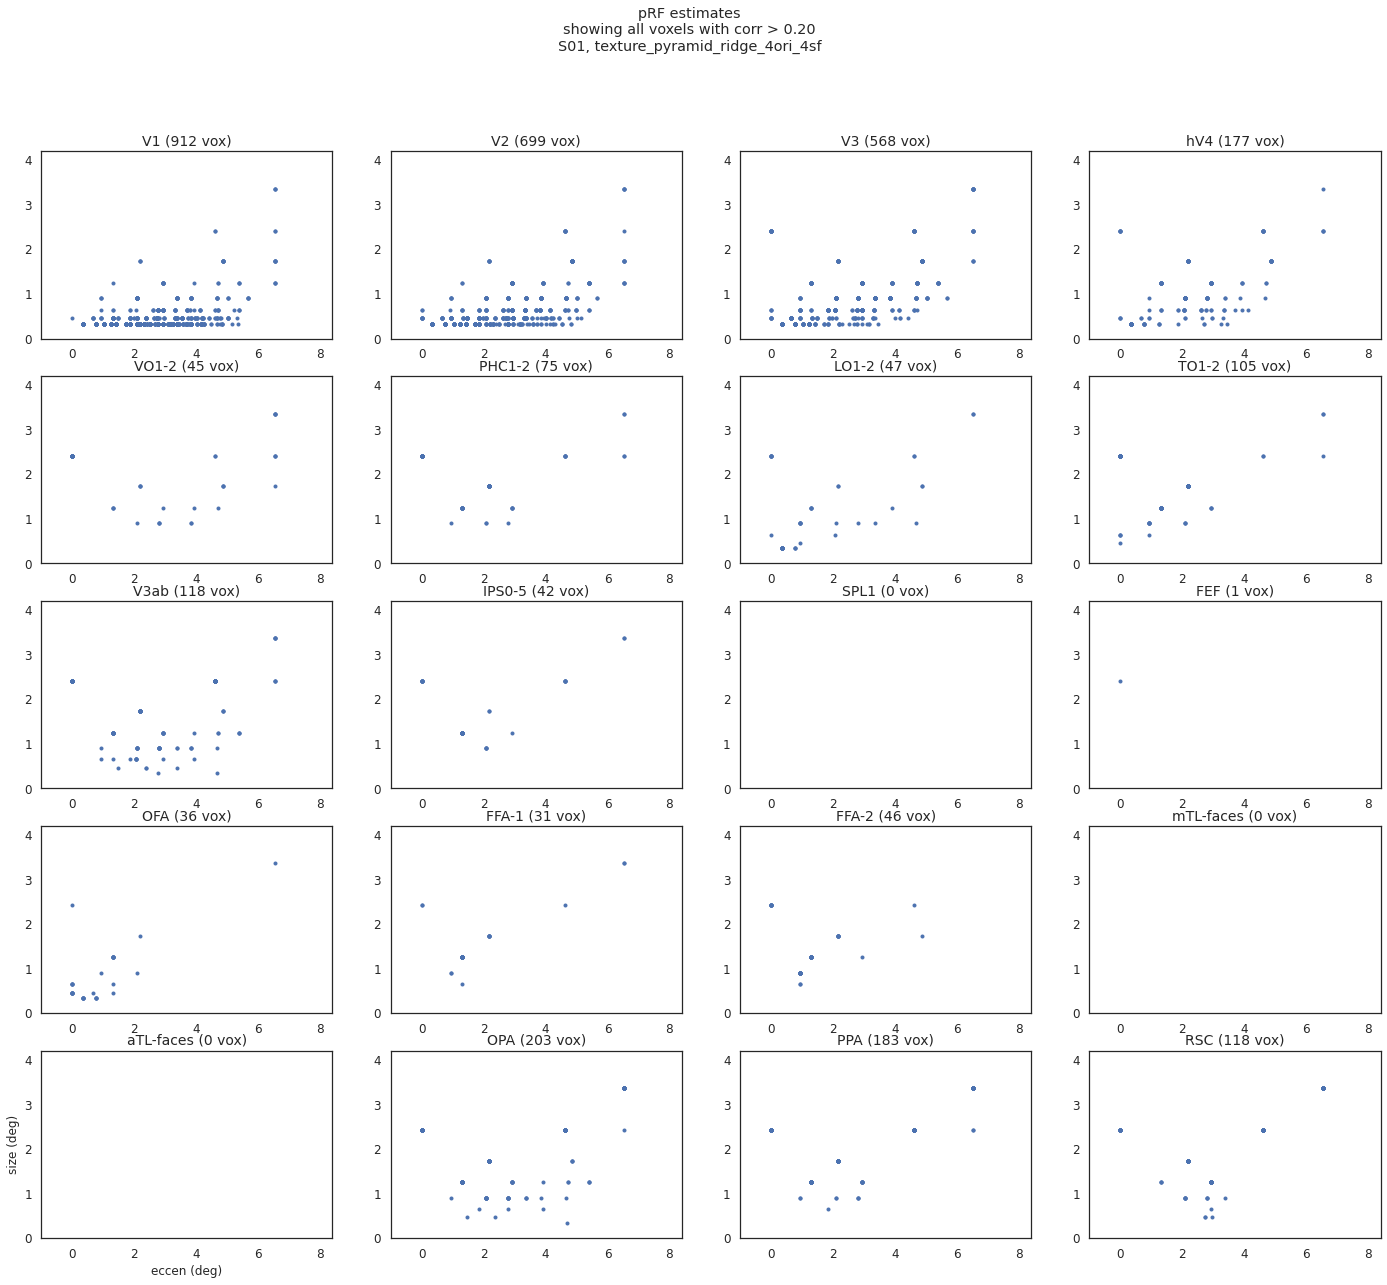

In [8]:
plot_utils.plot_size_vs_eccen(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)

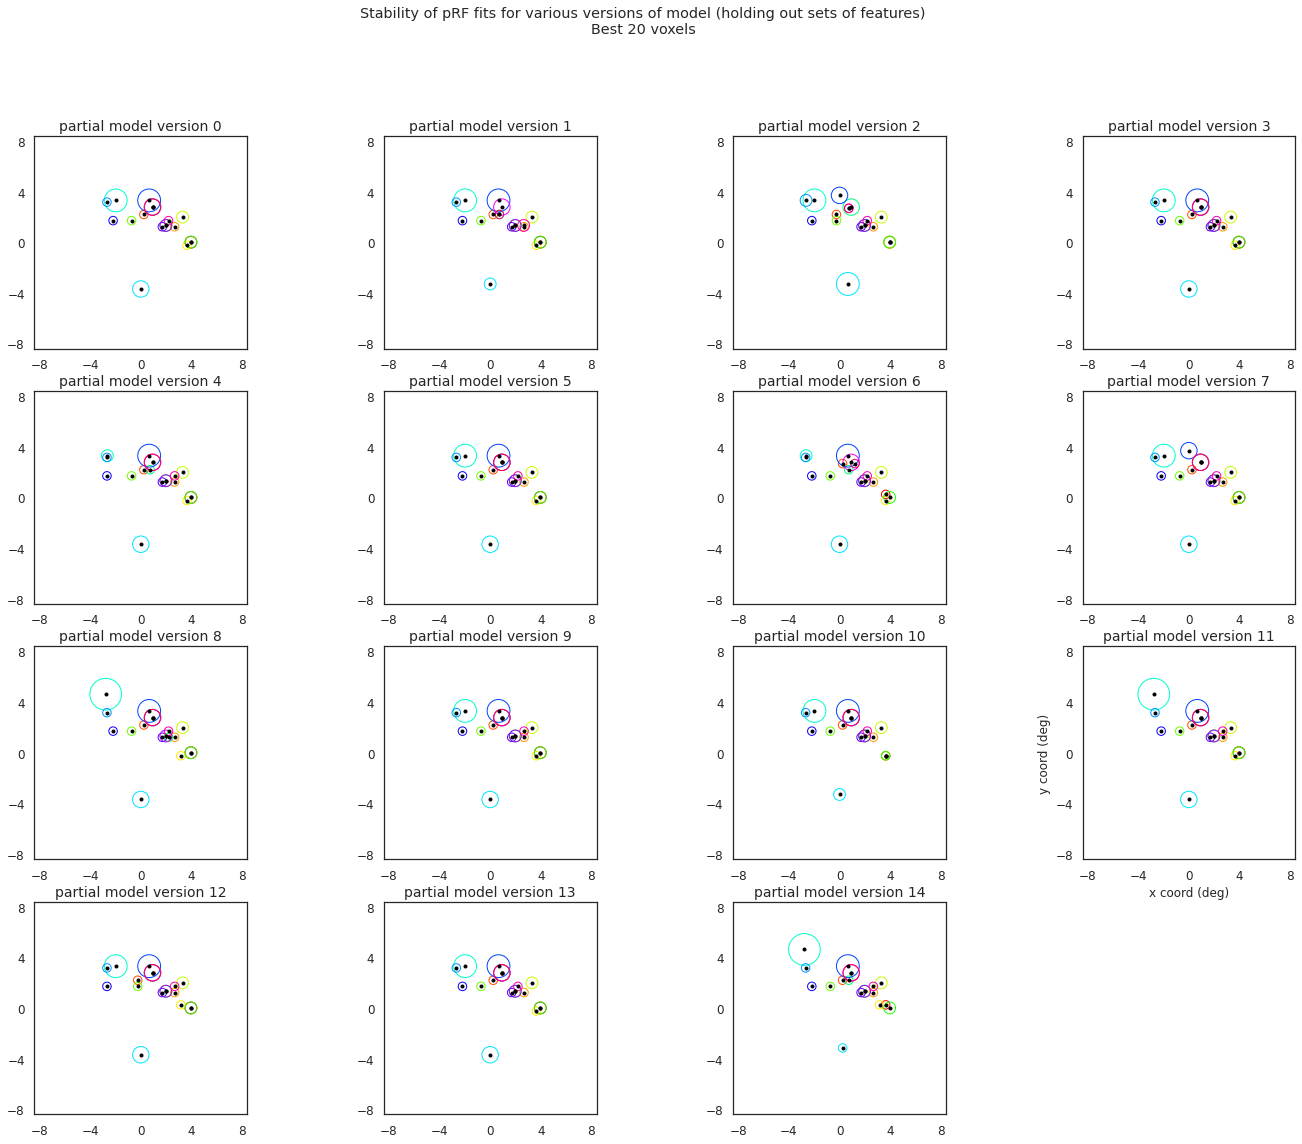

In [3]:
plot_utils.plot_prf_stability_partial_versions(subject, out, cc_cutoff = 0.2, screen_eccen_deg = 8.4, fig_save_folder=fig_save_folder)


['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']


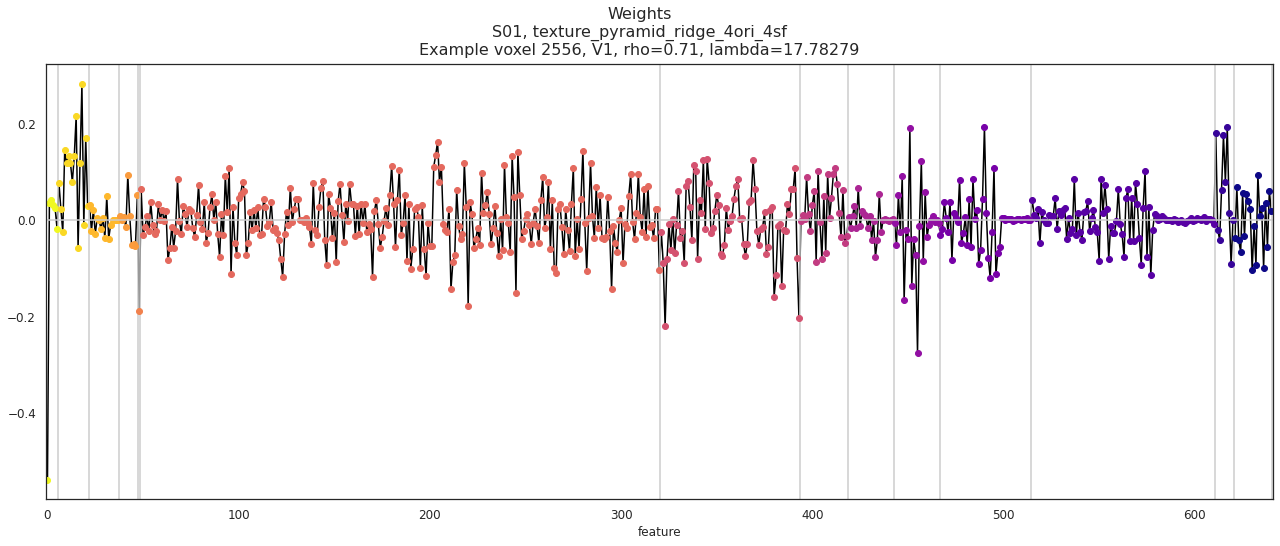

In [5]:
plot_utils.plot_example_weights_texture(subject, fitting_type, out, fig_save_folder)

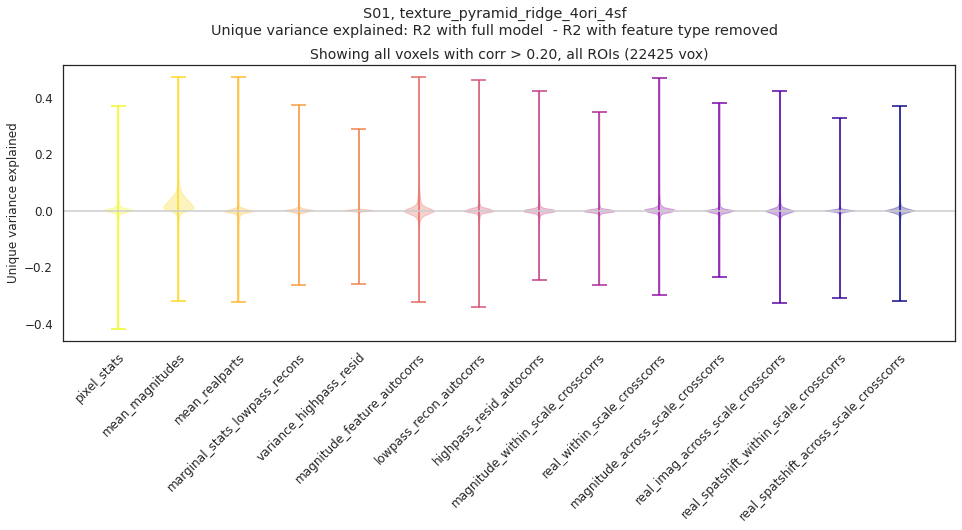

In [6]:
plot_utils.plot_uniqvar_violin_texture(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)


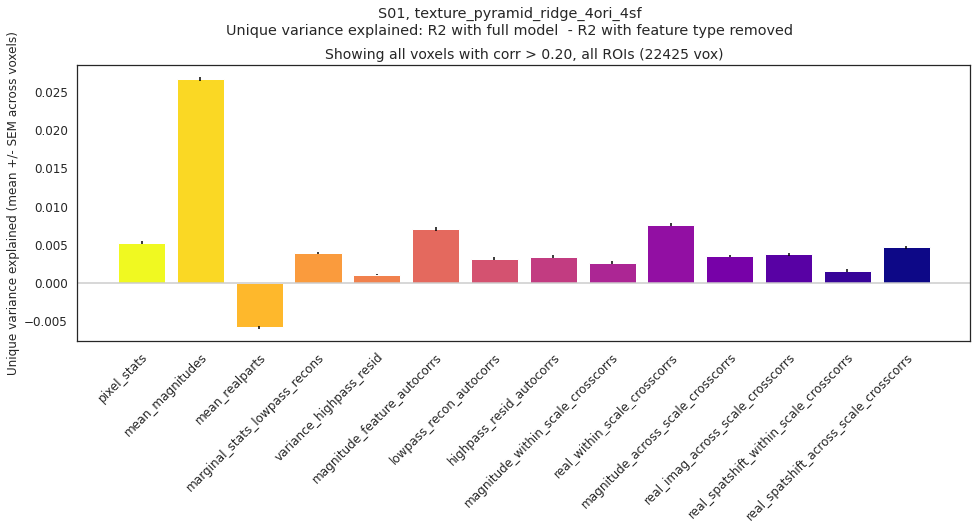

In [8]:
plot_utils.plot_uniqvar_bars_texture(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)


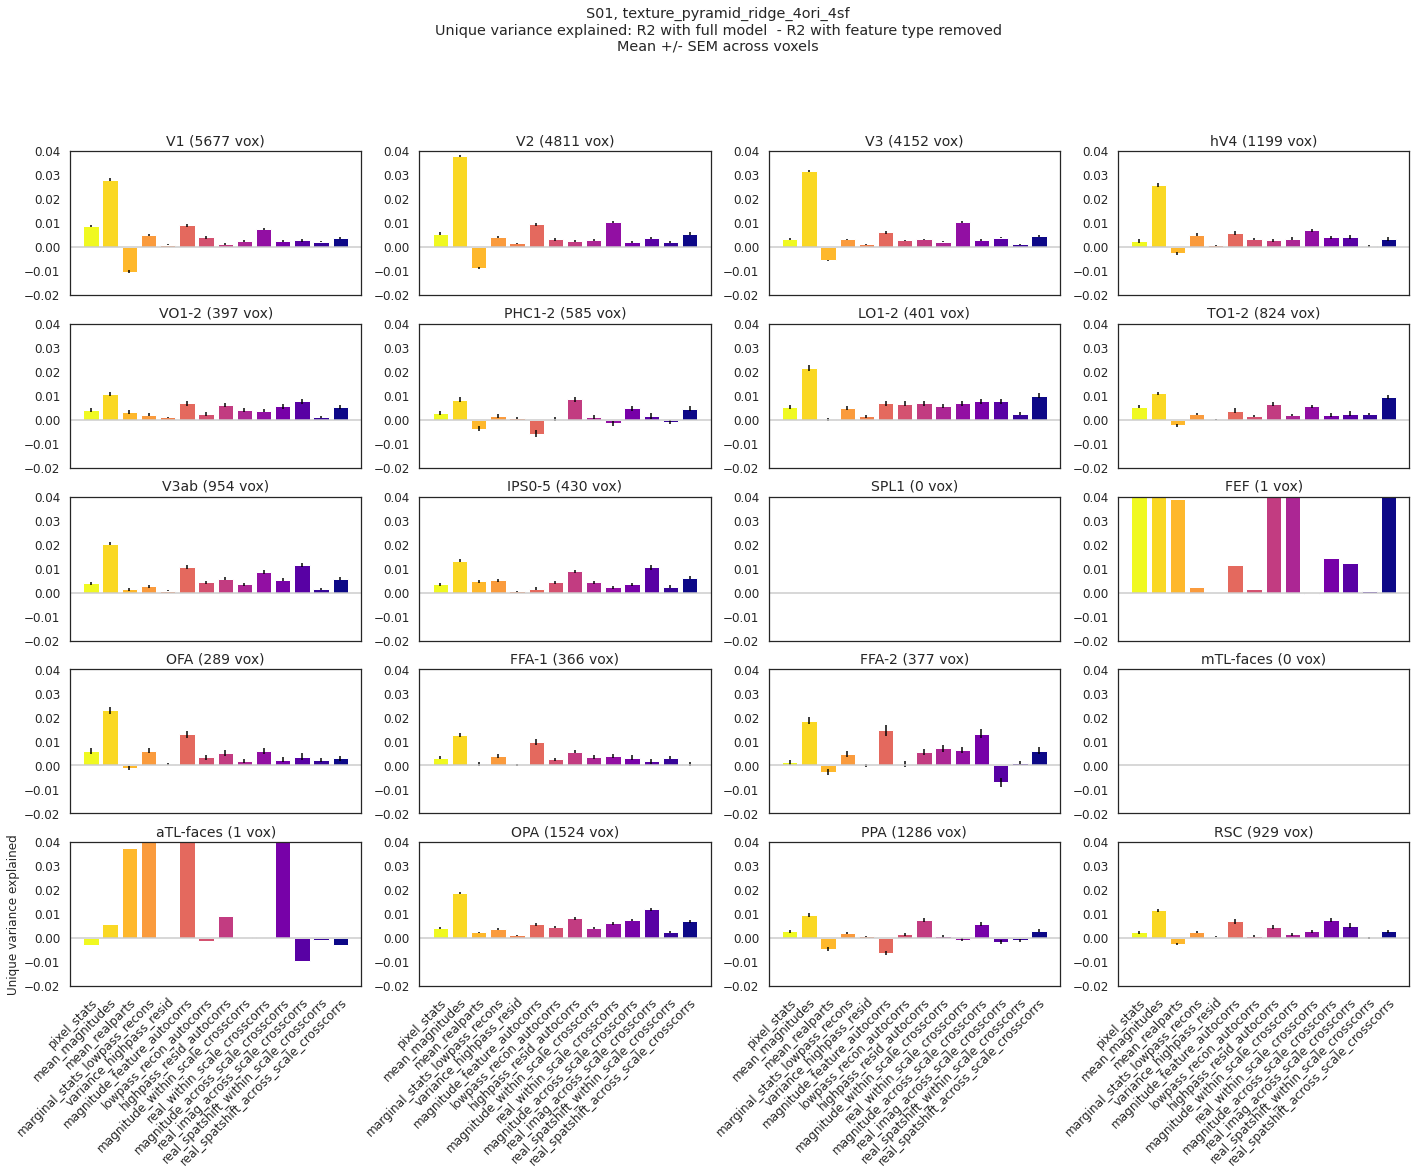

In [9]:
plot_utils.plot_uniqvar_bars_eachroi_texture(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)

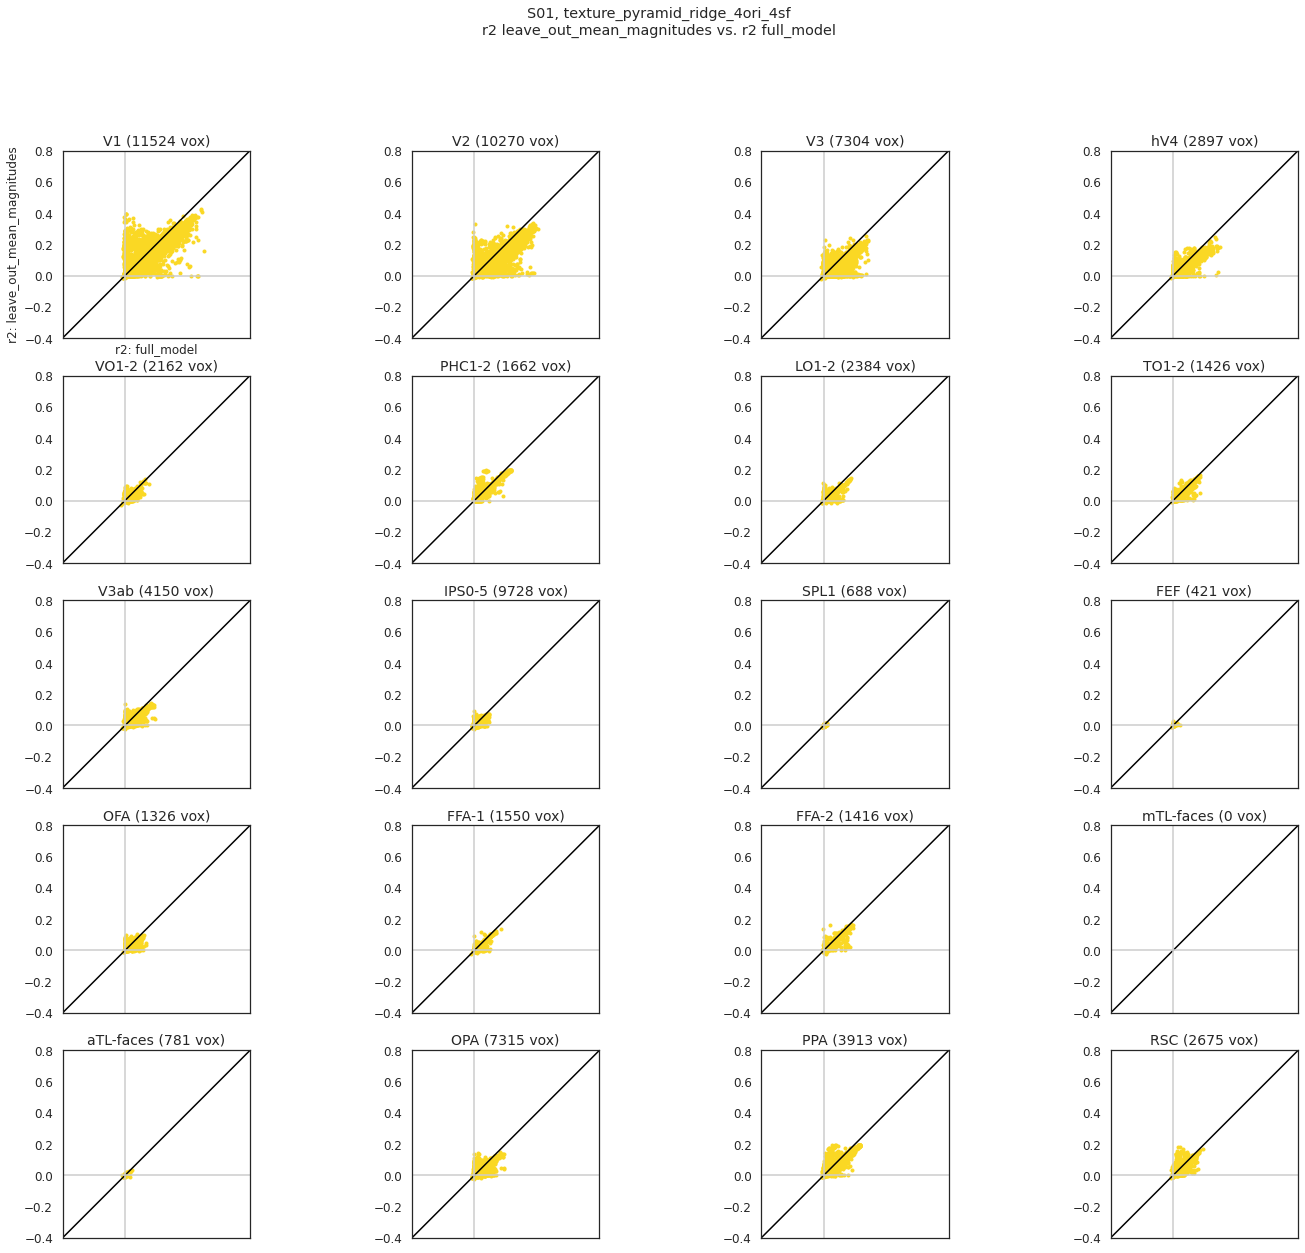

In [3]:
plot_utils.scatter_compare_partial_models(subject, fitting_type, out, pp1=0, pp2=2, fig_save_folder=fig_save_folder)

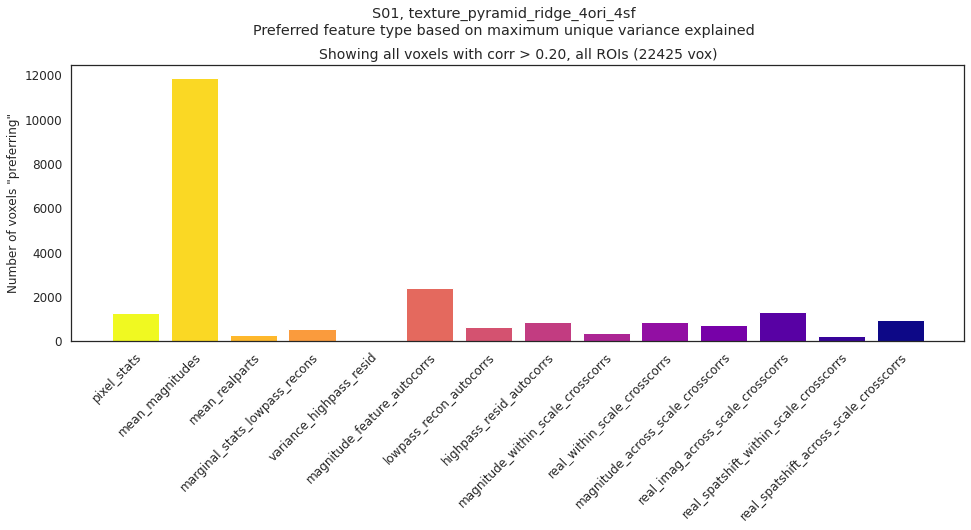

In [4]:
plot_utils.plot_feature_prefs_uniqvar_texture(subject, fitting_type, out, cc_cutoff = 0.2, fig_save_folder=fig_save_folder)

/user_data/mmhender/imStat/code/utils/plot_utils.py:1004: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(npx,npy,rr+1)


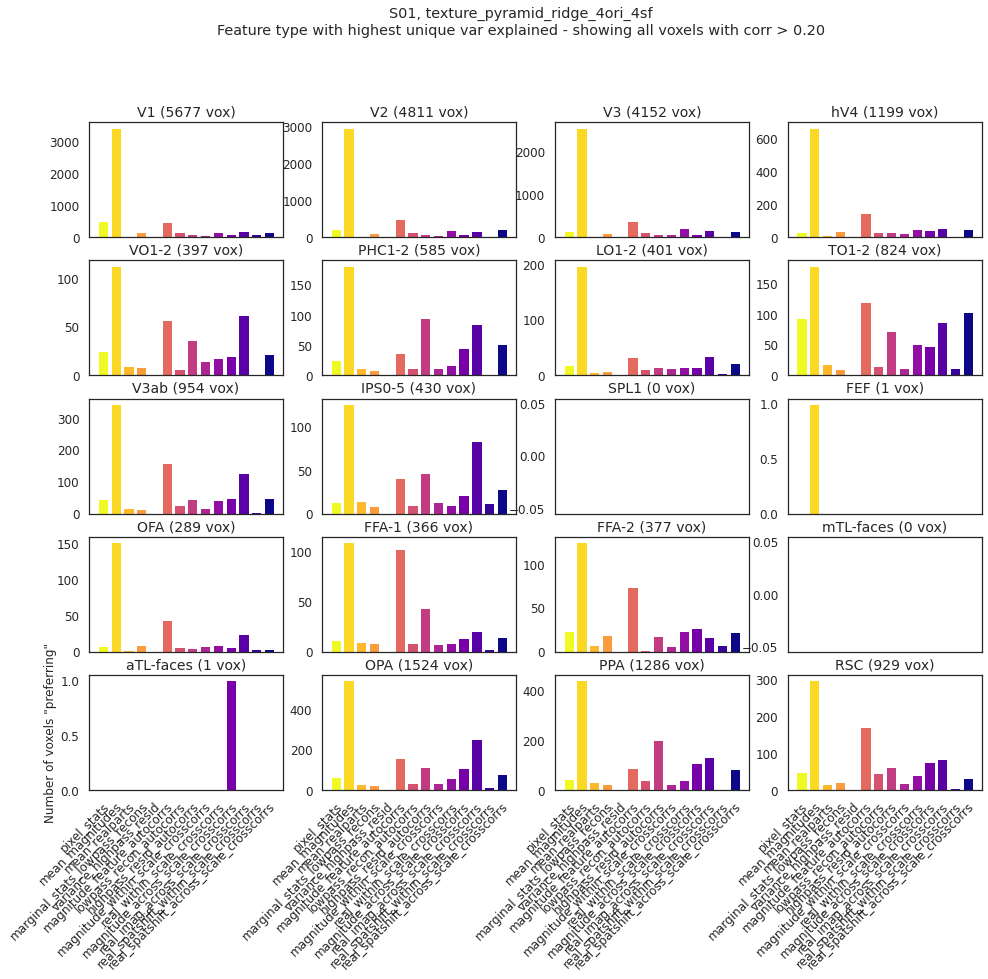

In [5]:
plot_utils.plot_feature_prefs_uniqvar_texture_eachroi(subject, fitting_type, out, cc_cutoff = 0.2, fig_save_folder=fig_save_folder)

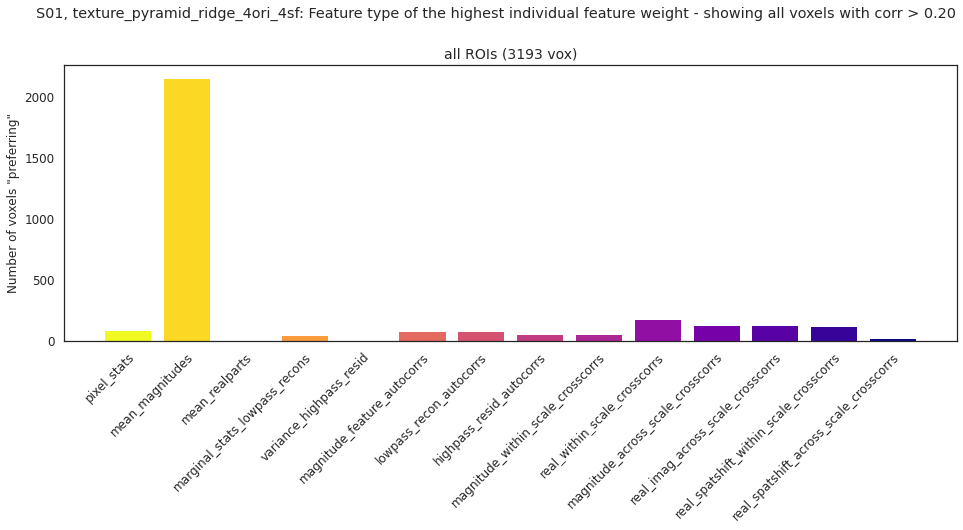

In [6]:
# Preferred feature type, based on highest encoding model weights.
import copy

fig = plt.figure(figsize=(16,8))
roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
        n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

weights = out['best_params'][1]
val_cc = out['val_cc']

feature_info = copy.deepcopy(out['feature_info'])
feature_type_labels, feature_type_names = feature_info
n_feature_types = len(feature_type_names)


colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

# mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(weights[:,feature_type_labels==ff], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
# max_wt = np.argmax(mean_weight_each_type, axis=1)

max_wt = feature_type_labels[np.argmax(weights[:,:,0],axis=1)]

cc_cutoff = 0.2

abv_thresh = val_cc[:,0]>cc_cutoff
inds2use = abv_thresh

unvals = np.arange(0,n_feature_types)
counts = [np.sum(np.logical_and(max_wt==ff, inds2use)) for ff in unvals]

# unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
for ff in range(n_feature_types):
    plt.bar(unvals[ff], counts[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
# plt.xlabel('feature type')
plt.ylabel('Number of voxels "preferring"')

plt.title('all ROIs (%d vox)'%( np.sum(inds2use)))

plt.suptitle('S%02d, %s: Feature type of the highest individual feature weight - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
# plt.suptitle('S%02d, %s: Feature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.gcf().subplots_adjust(bottom=0.4)
plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features_allrois.pdf'))
plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features_allrois.png'))

In [36]:
feature_type_labels[0]

0

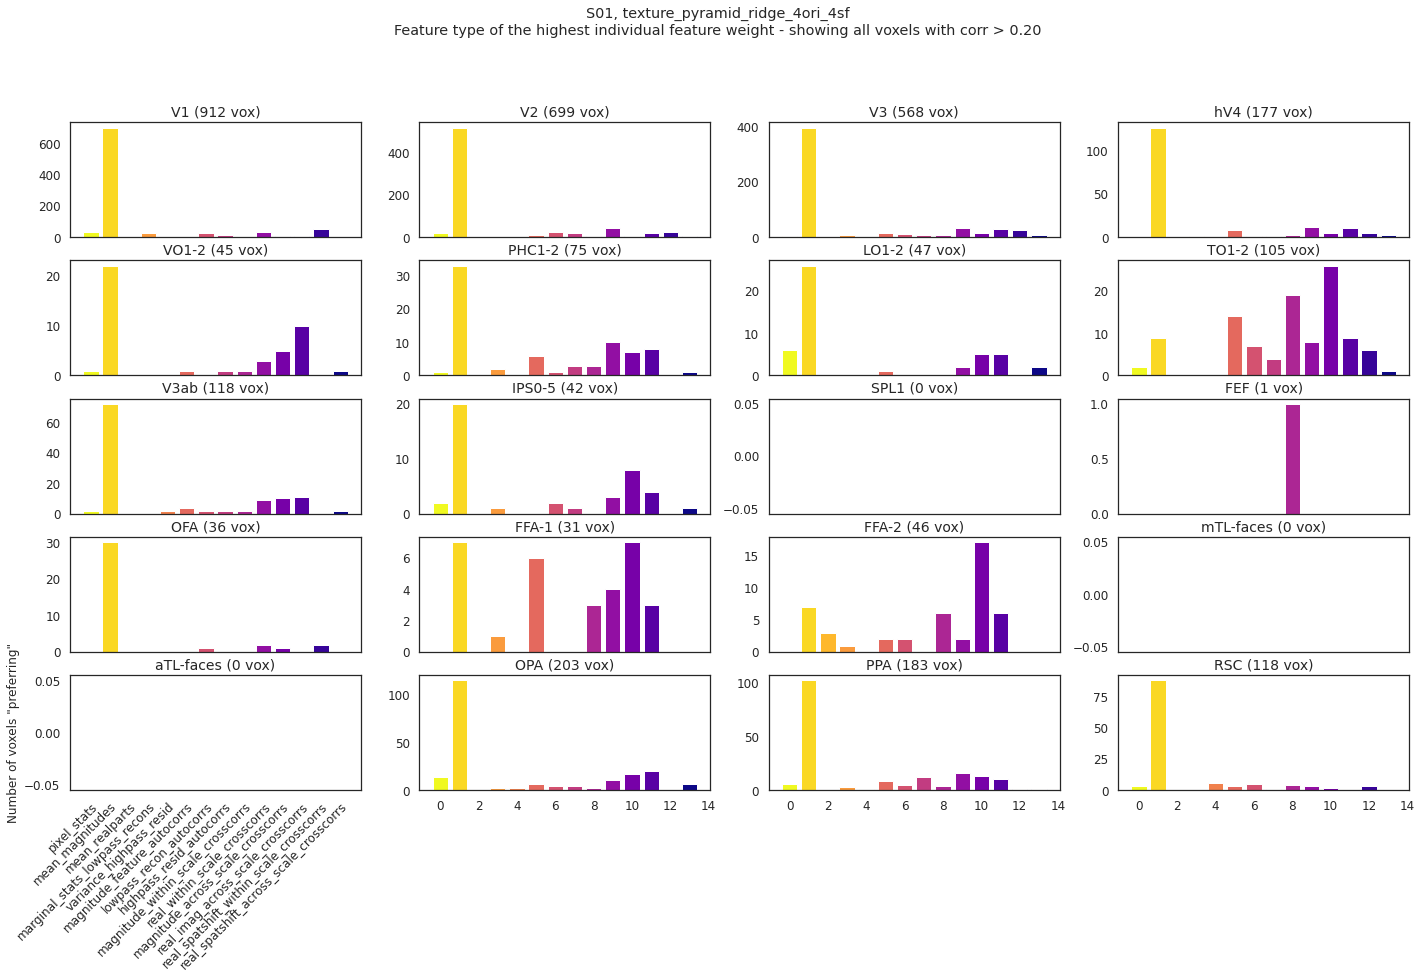

In [24]:
# Preferred feature type, based on encoding model weights. Separate plot each ROI.

fig = plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

# mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(weights[:,feature_type_labels==ff], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
# max_wt = np.argmax(mean_weight_each_type, axis=1)

max_wt = feature_type_labels[np.argmax(weights[:,:,0],axis=1)]

cc_cutoff = 0.2

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc[:,0]>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
#     unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
    unvals = np.arange(0,n_feature_types)
    counts = [np.sum(max_wt[inds2use]==ff) for ff in range(n_feature_types)]
    for ff in range(len(unvals)):
        plt.bar(unvals[ff], counts[ff], color=colors[ff,:])
 
    
    if rr==n_rois-4:
        plt.ylabel('Number of voxels "preferring"')
        plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
#         fig.autofmt_xdate()
    elif rr<n_rois-4:
        plt.xticks([])
#         plt.yticks([])

    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nFeature type of the highest individual feature weight - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
# plt.suptitle('S%02d, %s\nFeature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features.pdf'))
plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features.png'))



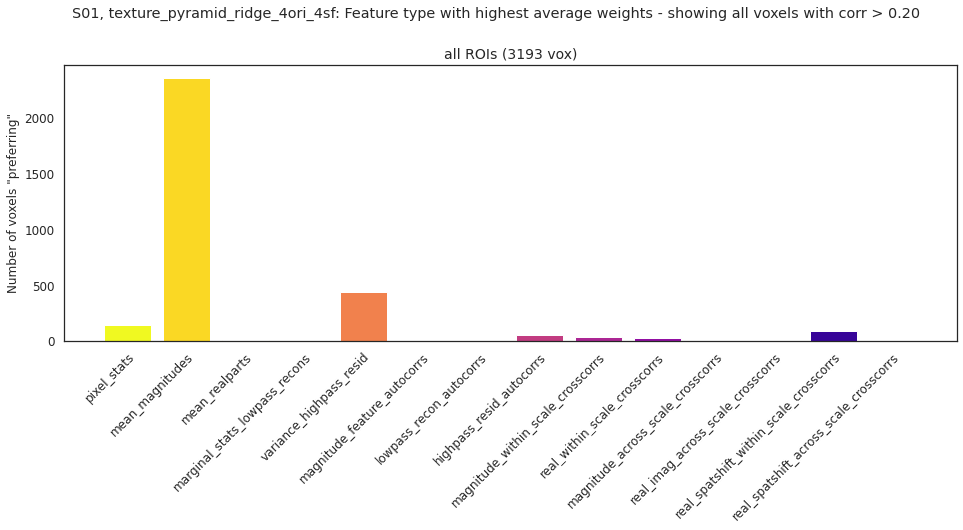

In [26]:
# Preferred feature type, based on highest average encoding model weights.

fig = plt.figure(figsize=(16,8))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(weights[:,feature_type_labels==ff,0], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
max_wt = np.argmax(mean_weight_each_type, axis=1)

# max_wt = feature_type_labels[np.argmax(weights[:,:,0],axis=1)]

cc_cutoff = 0.2

abv_thresh = val_cc[:,0]>cc_cutoff
inds2use = abv_thresh

unvals = np.arange(0,n_feature_types)
counts = [np.sum(np.logical_and(max_wt==ff, inds2use)) for ff in unvals]

# unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
for ff in range(n_feature_types):
    plt.bar(unvals[ff], counts[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
# plt.xlabel('feature type')
plt.ylabel('Number of voxels "preferring"')

plt.title('all ROIs (%d vox)'%( np.sum(inds2use)))

plt.suptitle('S%02d, %s: Feature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
# plt.suptitle('S%02d, %s: Feature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.gcf().subplots_adjust(bottom=0.4)
# plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features_allrois.pdf'))
# plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features_allrois.png'))

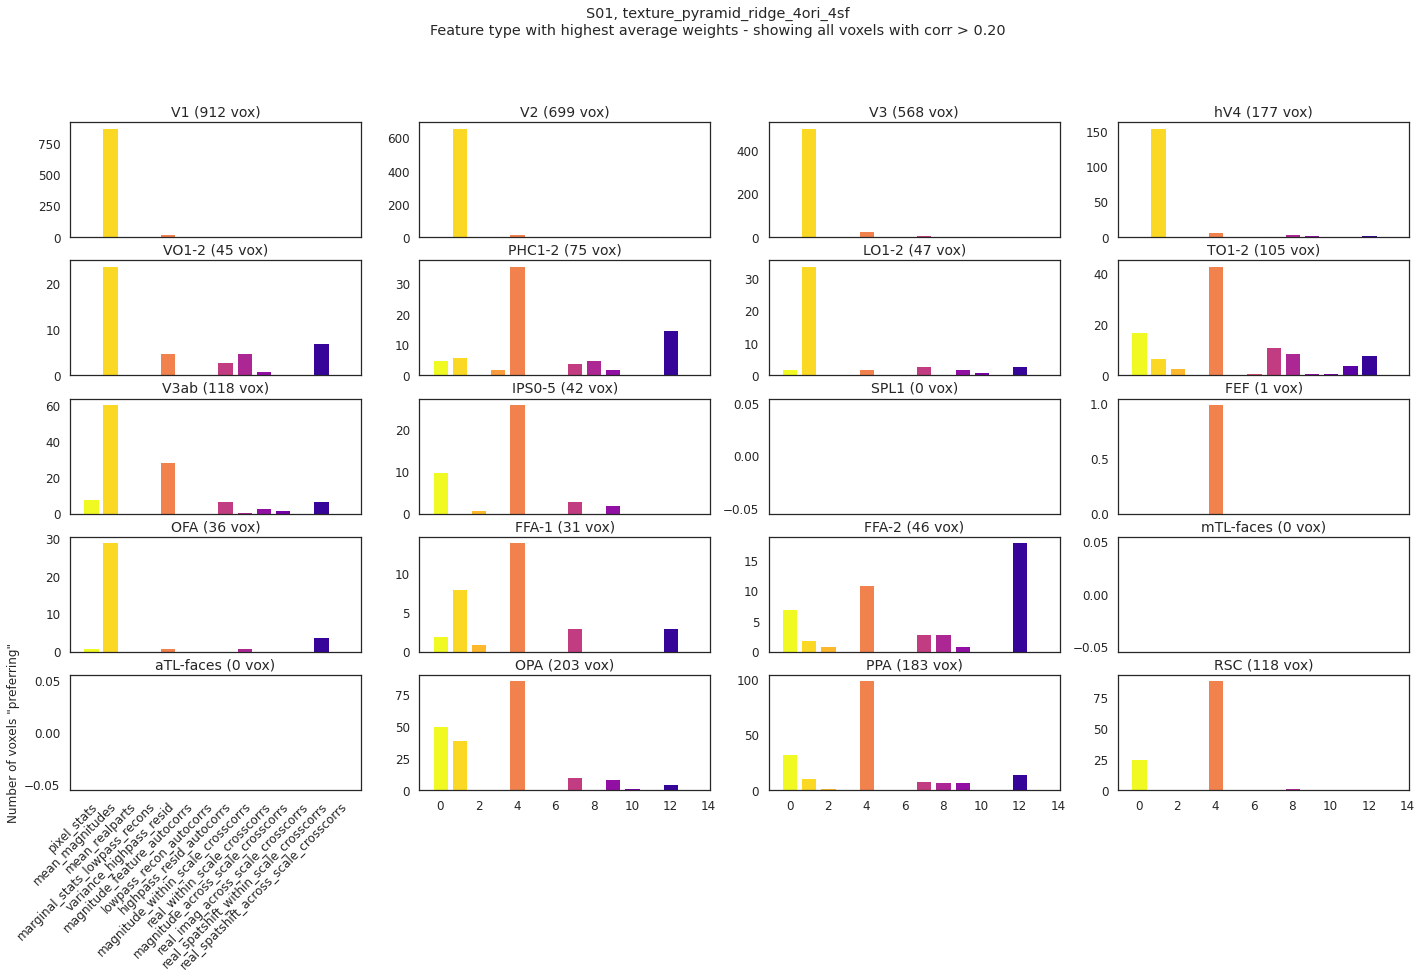

In [28]:
# Preferred feature type, based on encoding model weights. Separate plot each ROI.

fig = plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(weights[:,feature_type_labels==ff,0], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
max_wt = np.argmax(mean_weight_each_type, axis=1)

# max_wt = feature_type_labels[np.argmax(weights[:,:,0],axis=1)]

cc_cutoff = 0.2

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc[:,0]>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
#     unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
    unvals = np.arange(0,n_feature_types)
    counts = [np.sum(max_wt[inds2use]==ff) for ff in range(n_feature_types)]
    for ff in range(len(unvals)):
        plt.bar(unvals[ff], counts[ff], color=colors[ff,:])
 
    
    if rr==n_rois-4:
        plt.ylabel('Number of voxels "preferring"')
        plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
#         fig.autofmt_xdate()
    elif rr<n_rois-4:
        plt.xticks([])
#         plt.yticks([])

    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nFeature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
# plt.suptitle('S%02d, %s\nFeature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.gcf().subplots_adjust(bottom=0.3)
# plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features.pdf'))
# plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features.png'))

